# Анализ комментариев в социальных сетях

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

В представленной задаче необходимо по тексту комментария степень его токсичности. Это задача классификации на $K$ классов, которые могут пересекаться $Y\in\{0,1\}^K$, возможные классы:
- toxic;
- severe_toxic;
- obscene;
- threat;
- insult;
- identity_hate.

Загрузим имеющиеся данные.

In [2]:
data = pd.read_csv('toxic_comment.csv', index_col=0)

In [3]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.loc['0001b41b1c6bb37e', 'comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

Проведем предварительный анализ. Для этого посмотрим на распределение классов.

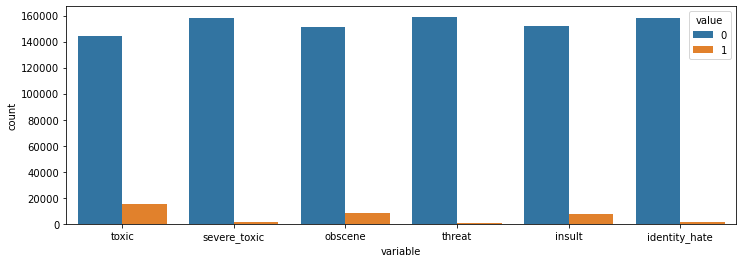

In [5]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(data.drop('comment_text', axis=1)))
plt.show()

Как видно из данного графика, классы несбалансированы. Это необходимо учитывать при оценке качества модели. Предварительно разобьем выборку на обучение и контроль:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], 
                                                    data.drop('comment_text', axis=1), 
                                                    test_size=0.33,
                                                    random_state=42)

Убедимся, что распределения в обучающем и тестовом наборах совпадают

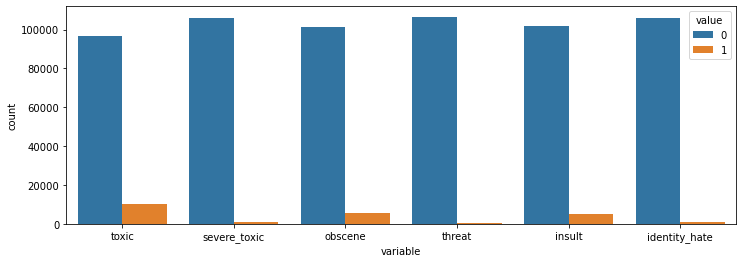

In [8]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(y_train))
plt.show()

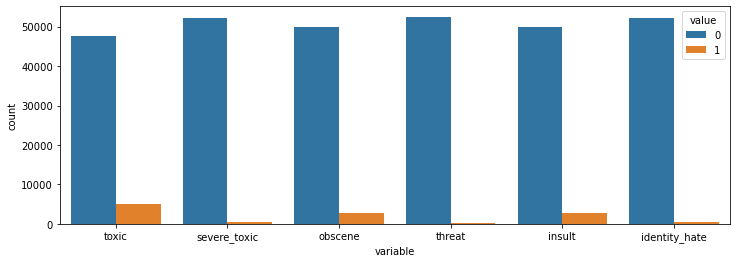

In [9]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(y_test))
plt.show()

## 1. Преобразование текстовых данных

Для преобразования текстов комментариев в числовые векторы воспользуемся методами `CountVectorizer` и `TfIdfVectorizer` из пакета `sklearn`.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Начнем с `TfidfVectorizer`. Чтобы составить корпус слов и посчитать число вхождений каждого слова в комментарии и его частоту встречаемости в других документах, необходимо последовательно применить функции `fit` и `transform` в `TfidfVectorizer`, или же сразу `fit_transform`.

In [11]:
count_vec = TfidfVectorizer(max_features=30000, sublinear_tf=True, 
                            strip_accents='unicode', analyzer='word', 
                            token_pattern=r'\w{1,}')

In [12]:
comments_vec_train = count_vec.fit_transform(X_train)

In [13]:
comments_vec_train

<106912x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 4701344 stored elements in Compressed Sparse Row format>

Таким образом `TfidfVectorizer` запоминает 30000 наиболее частых слов, которые встречались в комментариях из `X_train`. Всего в корпусе оказалось 149271 слово. Теперь необходимо посчитать количество вхождений каждого из слов корпуса для тестового набора:

In [14]:
comments_vec_test = count_vec.transform(X_test)

In [15]:
comments_vec_test

<52659x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2307197 stored elements in Compressed Sparse Row format>

## 2. Построение модели логистической регрессии

Решение задачи классификации на пересекающихся $K$ классов может быть сведено к решению $K$ задач бинарной классификации. В задачах с большим количеством признаков хорошие результаты показывают линейные модели.

<div class="alert alert-info">

<h3> Задание 1.</h3>
<p></p>

 <ol>
  <li>Решить поставленную задачу с помощью модели логистической регрессии. Для этого необходимо обучить 6 моделей на полученных векторах текстов comments_vec_train и каждом из столбцов y_train.</li>
 <p></p>

      
  <li>Для тестового набора данных comments_vec_test предсказать, принадлежит ли комментарий к каждому из 6 классов с помощью метода predict.</li>
<p></p>
  

 </ol> 
</div>

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model = LogisticRegression(random_state=42, C=1)

In [18]:
model.fit(comments_vec_train, y_train['toxic'])

LogisticRegression(C=1, random_state=42)

In [19]:
pred = model.predict(comments_vec_test)

In [20]:
model.predict_proba(comments_vec_test)

array([[0.77957506, 0.22042494],
       [0.99043438, 0.00956562],
       [0.9428024 , 0.0571976 ],
       ...,
       [0.99723189, 0.00276811],
       [0.99570929, 0.00429071],
       [0.92242423, 0.07757577]])

## 3. Оценка качества модели

Для оценки качества каждой из моделей воспользуемся F-мерой. Оценка качества по всем 6 классам будет проводиться по следующей формуле:
$$F1=\frac{1}{6}\sum_{i=1}^6f1_i$$

<div class="alert alert-info">

<h3> Задание 2.</h3>
<p></p>

 <ol>
  <li>Оценить качество полученной модели по всем 6 классам.</li>
 <p></p>

      
  <li>Провести преобразование текста с помощью метода CountVectorizer и построить модель логистической регрессии аналогично заданию 1. Какого качества удалось достичь?</li>
<p></p>
     
  <li>Рассмотрите другие параметры Tf-Idf преобразования (lowercase, analyzer, stop_words, ngram_range, max_features) и попробуйте улучшить качество предсказаний.</li>
<p></p>
  

 </ol> 
</div>

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(y_test['toxic'], pred)

0.3228891820580475

In [22]:
count_vec = CountVectorizer(max_features=30000, 
                            strip_accents='unicode', analyzer='word', 
                            token_pattern=r'\w{1,}')

In [23]:
comments_vec_train = count_vec.fit_transform(X_train)

In [29]:
model = LogisticRegression(random_state=42, C=1)
model.fit(comments_vec_train, y_train['toxic'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, random_state=22)

In [30]:
pred = model.predict(comments_vec_test)

In [31]:
model.predict_proba(comments_vec_test)

array([[0.9349537 , 0.0650463 ],
       [0.96130106, 0.03869894],
       [0.92632962, 0.07367038],
       ...,
       [0.96431707, 0.03568293],
       [0.97631996, 0.02368004],
       [0.9454751 , 0.0545249 ]])

In [35]:
f1_score(y_test['toxic'], pred)

0.3228891820580475

### Другие параметры Tf-Idf

In [38]:
count_vec = TfidfVectorizer(max_features=30000, sublinear_tf=True, \
                            strip_accents='unicode', analyzer='char_wb', \
                            token_pattern=r'\w{1,}', lowercase = False,\
                            ngram_range=(1,5))

In [39]:
comments_vec_train = count_vec.fit_transform(X_train)

In [40]:
comments_vec_test = count_vec.transform(X_test)

In [41]:
model.fit(comments_vec_train, y_train['toxic'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, random_state=22)

In [42]:
pred = model.predict(comments_vec_test)

In [46]:
probs = model.predict_proba(comments_vec_test)

In [44]:
f1_score(y_test['toxic'], pred)

0.740886928256327

## 3. Выбор порога округления

По умолчанию в функции `LogicticRegression` все объекты, имеющие вероятность $p>0.5$ относятся к классу 1, однако из-за дисбаланса классов многие объекты ошибочно были отнесены к классу 0. Выбрать порог округления можно самостоятельно таким образом, чтобы качество классификации по выбранной метрике было наилучшим.

<div class="alert alert-info">

<h3> Задание 3.</h3>
<p></p>

 <ol>
  С помощью метода predict_proba у LogisticRegression получить вероятности принадлежности объектов к классу 1. Выбрать порог округления для каждого из классов таким образом, чтобы F-мера была наибольшей.
<p></p>
  

 </ol> 
</div>

In [49]:
probs.T[0]

array([0.88965091, 0.98834709, 0.97754362, ..., 0.99570496, 0.99599073,
       0.88362873])